# Realtime annotations

## Setup
- GPU or not? `USE_GPU`
- disable eager execution speeds up ~6x

In [2]:
import os
USE_GPU = True  # USE_MP should be False if USE_GPU for best performance
nb_gpu = 1 if USE_GPU else 0
os.environ['CUDA_VISIBLE_DEVICES'] = '0' if USE_GPU else '-1'
try:
    import tensorflow as tf
    from tensorflow.python.framework.ops import disable_eager_execution
    disable_eager_execution()
    physical_devices = tf.config.list_physical_devices('GPU') 
    print(physical_devices)
    USE_GPU = len(physical_devices)>0
except:
    pass

[]


In [3]:
import numpy as np
import dss.utils
import dss.predict
import scipy.signal
import matplotlib.pyplot as plt
import scipy.io.wavfile
import time
import subprocess

plt.style.use('ncb.mplstyle')

## Load the model and runtime parameters

In [4]:
model_filename = 'models/dmel_single_rt/20200430_201821'
model, params = dss.utils.load_model_and_params(model_filename)

pulse_index = params['class_names'].index('pulse')
sine_index = params['class_names'].index('sine')

samplerate = params['samplerate_x_Hz']
interval = params['nb_hist'] / samplerate
print(f"Model expects input shape {model.input_shape[1]} samples and {model.input_shape[2]} channel(s).")

Model expects input shape 256 samples and 1 channel(s).


## Load a recording
Samplerates of the recording and of the data the model was trained with should match. Otherwise resample the recording to match the model using `scipy.signal.resample_poly(x=recording, up=int(recording_samplerate), down=int(samplerate), axis=0)`

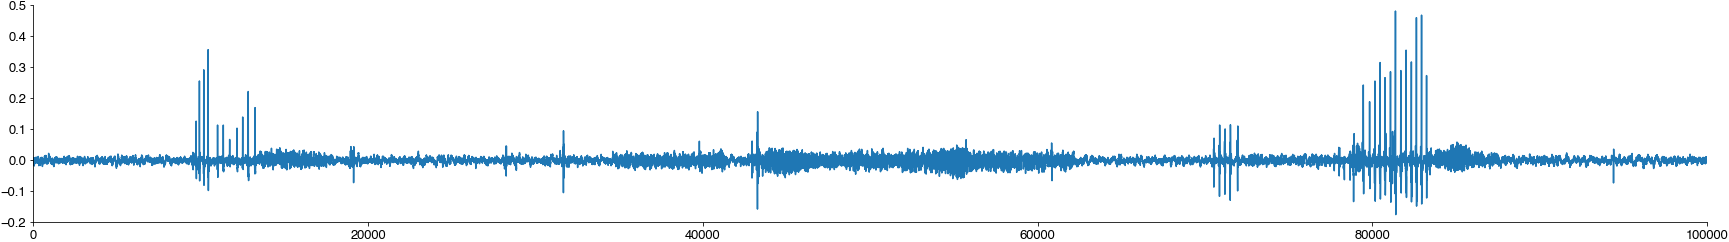

Sample rate of the recording (10000Hz), sample rate expected by the model (10000Hz). Both should match.


In [5]:
recording_samplerate, recording = scipy.io.wavfile.read('dat/dmel_song_rt.wav')
recording = np.atleast_2d(recording).T
plt.figure(figsize=(30, 4))
plt.plot(recording[:100_000])  # plot the first 10 seconds
plt.show()
print(f"Sample rate of the recording ({recording_samplerate}Hz), sample rate expected by the model ({samplerate}Hz). Both should match.")

## Define a virtual microphone
The microphone takes a full recording and returns a chunk of data at regular intervals given by the chunk duration.

Microphone produces 256 samples and 1 channel(s) per chunk.
Consuming and plotting 100 chunks...


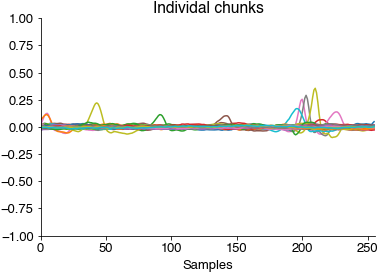

Takes 26.3 ms to return 25.6 ms of audio data.


In [6]:
def virtual_microphone(data: np.array, interval: float, samplerate: float, block: bool = True):
    
    RUN = True
    current_position = 0
    t1 = time.time() - 0.025
    t0 = time.time()    
    while RUN:
        current_position += interval * samplerate 
        start_sample = int(current_position)
        end_sample = int(current_position + interval * samplerate)
        chunk = data[start_sample:end_sample]
        if block:
            while (t1-t0)<interval:  # wait til interval has elapsed
                time.sleep(0.001)
                t1 = time.time()
        if end_sample >= data.shape[0]:
            RUN = False
            yield None
        else:
            yield chunk
        t0 = time.time()
        
        # t1 = t0


mike = virtual_microphone(recording, interval, samplerate, block=True)
rec = next(mike)
print(f"Microphone produces {rec.shape[0]} samples and {rec.shape[1]} channel(s) per chunk.")

print('Consuming and plotting 100 chunks...')
recording_latencies = []
for _ in range(100):
    with dss.utils.Timer() as t:
        rec = next(mike)
    recording_latencies.append(t.elapsed * 1000)
    plt.plot(rec)
    plt.ylim(-1, 1)
plt.title('Individal chunks')
plt.xlabel('Samples')
plt.xlim(0, rec.shape[0])
plt.show()
print(f"Takes {np.median(recording_latencies):1.1f} ms to return {rec.shape[0] / samplerate * 1000:1.1f} ms of audio data.")

## Define simple detection
demonstrate with chunk with sine and pulse

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


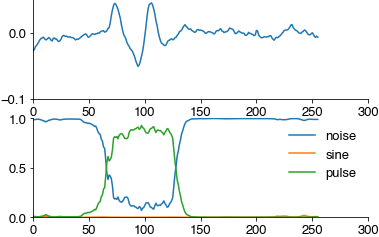

In [7]:
def report_song(prediction, pulse_index, sine_index):
    report = 'pulse? ' + ('yes' if np.max(out[:, pulse_index]) > 0.7 else ' no')
    report += ' sine? ' + ('yes' if np.max(out[:, sine_index]) > 0.7 else ' no')
    return report

for _ in range(9):
    d = next(mike)
d = d[np.newaxis, ...]
out = model.predict(d, verbose=0)
plt.subplot(211)
plt.plot(d[0, ...])
plt.subplot(212)
plt.plot(out[0])
plt.legend(params['class_names'])

## Run inference
estimate latencies

In [14]:
latencies = []
runs = 0

while runs < 100:
    runs += 1
    with dss.utils.Timer() as dt:
        d = next(mike)  # get a new chunk
        d = d[np.newaxis, ...]
        out = model.predict(d, verbose=0)  # run inference on the chunk
        # detect pulse and sine
        print(report_song(out[0, ...], pulse_index, sine_index))
    latencies.append(dt.elapsed * 1000)


pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no sine?  no
pulse?  no sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no sine?  no
pulse?  no sine? yes
pulse?  no sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no si

## Evaluate latencies
Timing on GPUs can be more variable than on CPUs since a major contributor to latency is the transfer of data from/to the GPU.
Hence, warmup!

Annotation latencies
  5, 50, 95 percentiles: [4.4279488 5.0589635 5.8320642] ms
  min 3.90 ms, max 6.00 ms


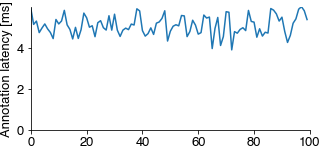

In [13]:
annotation_latencies = np.array(latencies) - np.median(recording_latencies)
print('Annotation latencies')
print(f'  5, 50, 95 percentiles: {np.percentile(annotation_latencies, [5, 50, 95])} ms')
print(f'  min {np.min(annotation_latencies):1.2f} ms, max {np.max(annotation_latencies):1.2f} ms')

plt.figure(figsize=(5, 5))
plt.subplot(211)
plt.plot(np.array(annotation_latencies))
plt.ylabel('Annotation latency [ms]')
plt.ylim(0, np.max(annotation_latencies))
plt.show()